## MA Models
**Road Map of Lesson**
- What are they  
- How they are represented/calculated in Python
- Modeling
- Review coefficients and use LL function to interpret model
- Review and interpret residuals
- Determine appropriate number of lag components to include to achieve an optimal model
- Determine the best representation from the prices to model e.g. prices, returns, normalized values etc

In [20]:
#module imports
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.tsa.stattools as sts
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats.distributions import chi2

In [47]:
#data prep / we are working with FTSE
raw_data = pd.read_csv('Index2018.csv')
data = raw_data.copy()

#date as index
data.date = pd.to_datetime(data.date, dayfirst = True)
data.set_index('date', inplace = True)
data = data.asfreq('b')
data = data.fillna(method='ffill')

#prepare FTSE only for use
data['market_value'] = data.ftse
del data['spx'], data['dax'], data['ftse'], data['nikkei']

#calculate returns since we will be using them at some point
data['returns'] = data.market_value.pct_change(1).mul(100)
#normalized returns
bench = data.returns.iloc[1]
data['norm_ret'] = data.returns.div(bench).mul(100)
#split for train and test
size = int(len(data)*0.8)
train = data[:size]
test = data[size:]

In [48]:
#method for LLR test
def LLR_test(mod_1, mod_2, DF=1):
    res1 = mod_1.fit()
    res2 = mod_2.fit()
    res1.summary()
    LR = 2*(res2.llf - res1.llf)
    print('P-Value for LLR:', chi2.sf(LR, DF).round(3))
    print('**Results Summary for Higher Order Model**')
    return res2.summary()

#method for displaying ACF and PCF
def ACF_and_PACF(series, title):
    fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize=(20,6))
    sgt.plot_acf(series, lags = 40, zero=False, ax=ax1)
    sgt.plot_pacf(series, lags = 40, zero=False, method = 'ols', ax=ax2)
    ax1.title.set_text('ACF Plot for ' + title)
    ax2.title.set_text('PACF Plot for ' + title)
    plt.show()

**MA Model:** Model of past residuals. Differs from AR models in that AR models past series values as opposed to past series residuals. To determine MA components we rely on the ACF correlogram while to determine AR components, we rely on the PACF correlogram

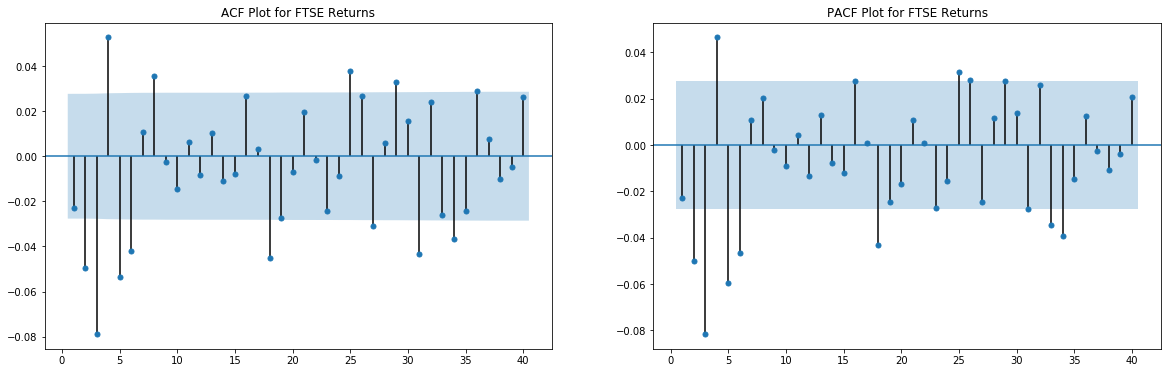

In [49]:
#plot ACF to determine number of lags
ACF_and_PACF(train.returns[1:], 'FTSE Returns')

**Simple MA model**
The correlogram tells us that the first lag is not significant but the next six are so an MA(7) may be a good fit and we should run an MA(8) model and use LLR test to see if the former is indeed the optimal model.

In [50]:
model_ret_ma1 = ARMA(train.returns[1:], order=(0,1))
result_ret_ma1 = model_ret_ma1.fit()
result_ret_ma1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(0, 1)   Log Likelihood               -7929.595
Method:                       css-mle   S.D. of innovations              1.174
Date:                Wed, 08 Apr 2020   AIC                          15865.190
Time:                        15:46:55   BIC                          15884.754
Sample:                    01-10-1994   HQIC                         15872.045
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0188      0.016      1.162      0.245      -0.013       0.050
ma.L1.returns    -0.0257      0.015     -1.720      0.085      -0.055       0.004
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           38.8547           +0.0000j           38.8547            0.0000
-----------------------------------------------------------------------------
"""

### Higher Lag MA Models
We attempt to add MA components until the LLR test fails

In [51]:
model_ret_ma1 = ARMA(train.returns[1:], order = (0,1))
model_ret_ma2 = ARMA(train.returns[1:], order = (0,2))
LLR_test(model_ret_ma1, model_ret_ma2)

P-Value for LLR: 0.0
**Results Summary for Higher Order Model**


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(0, 2)   Log Likelihood               -7922.864
Method:                       css-mle   S.D. of innovations              1.173
Date:                Wed, 08 Apr 2020   AIC                          15853.728
Time:                        15:46:55   BIC                          15879.812
Sample:                    01-10-1994   HQIC                         15862.868
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0188      0.015      1.239      0.215      -0.011       0.049
ma.L1.returns    -0.0327      0.014     -2.297      0.022      -0.061      -0.005
ma.L2.returns    -0.0502      0.014     -3.669      0.000      -0.077      -0.023
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            4.1499           +0.0000j            4.1499            0.0000
MA.2           -4.8004           +0.0000j            4.8004            0.5000
-----------------------------------------------------------------------------
"""

In [52]:
model_ret_ma2 = ARMA(train.returns[1:], order = (0,2))
model_ret_ma3 = ARMA(train.returns[1:], order = (0,3))
LLR_test(model_ret_ma2, model_ret_ma3)

P-Value for LLR: 0.0
**Results Summary for Higher Order Model**


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(0, 3)   Log Likelihood               -7904.317
Method:                       css-mle   S.D. of innovations              1.168
Date:                Wed, 08 Apr 2020   AIC                          15818.634
Time:                        15:46:57   BIC                          15851.240
Sample:                    01-10-1994   HQIC                         15830.060
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.014      1.376      0.169      -0.008       0.046
ma.L1.returns    -0.0203      0.014     -1.423      0.155      -0.048       0.008
ma.L2.returns    -0.0556      0.013     -4.134      0.000      -0.082      -0.029
ma.L3.returns    -0.0904      0.015     -6.121      0.000      -0.119      -0.061
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            2.0105           -0.0000j            2.0105           -0.0000
MA.2           -1.3129           -1.9441j            2.3459           -0.3445
MA.3           -1.3129           +1.9441j            2.3459            0.3445
-----------------------------------------------------------------------------
"""

In [53]:
model_ret_ma3 = ARMA(train.returns[1:], order = (0,3))
model_ret_ma4 = ARMA(train.returns[1:], order = (0,4))
LLR_test(model_ret_ma3, model_ret_ma4)

P-Value for LLR: 0.001
**Results Summary for Higher Order Model**


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(0, 4)   Log Likelihood               -7898.773
Method:                       css-mle   S.D. of innovations              1.167
Date:                Wed, 08 Apr 2020   AIC                          15809.547
Time:                        15:46:59   BIC                          15848.674
Sample:                    01-10-1994   HQIC                         15823.257
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.014      1.305      0.192      -0.009       0.047
ma.L1.returns    -0.0203      0.014     -1.443      0.149      -0.048       0.007
ma.L2.returns    -0.0551      0.014     -3.902      0.000      -0.083      -0.027
ma.L3.returns    -0.0922      0.015     -6.306      0.000      -0.121      -0.064
ma.L4.returns     0.0454      0.014      3.338      0.001       0.019       0.072
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           -1.2257           -1.4206j            1.8763           -0.3633
MA.2           -1.2257           +1.4206j            1.8763            0.3633
MA.3            2.2405           -1.1103j            2.5006           -0.0732
MA.4            2.2405           +1.1103j            2.5006            0.0732
-----------------------------------------------------------------------------
"""

In [54]:
model_ret_ma4 = ARMA(train.returns[1:], order = (0,4))
model_ret_ma5 = ARMA(train.returns[1:], order = (0,5))
LLR_test(model_ret_ma4, model_ret_ma5)

P-Value for LLR: 0.001
**Results Summary for Higher Order Model**


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(0, 5)   Log Likelihood               -7892.823
Method:                       css-mle   S.D. of innovations              1.166
Date:                Wed, 08 Apr 2020   AIC                          15799.645
Time:                        15:47:04   BIC                          15845.294
Sample:                    01-10-1994   HQIC                         15815.641
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.014      1.376      0.169      -0.008       0.046
ma.L1.returns    -0.0262      0.014     -1.851      0.064      -0.054       0.002
ma.L2.returns    -0.0497      0.014     -3.518      0.000      -0.077      -0.022
ma.L3.returns    -0.0852      0.015     -5.799      0.000      -0.114      -0.056
ma.L4.returns     0.0458      0.014      3.374      0.001       0.019       0.072
ma.L5.returns    -0.0500      0.014     -3.454      0.001      -0.078      -0.022
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           -1.2127           -1.0805j            1.6242           -0.3842
MA.2           -1.2127           +1.0805j            1.6242            0.3842
MA.3            1.7305           -0.0000j            1.7305           -0.0000
MA.4            0.8062           -1.9326j            2.0940           -0.1871
MA.5            0.8062           +1.9326j            2.0940            0.1871
-----------------------------------------------------------------------------
"""

In [55]:
model_ret_ma1 = ARMA(train.returns[1:], order = (0,5))
model_ret_ma2 = ARMA(train.returns[1:], order = (0,6))
LLR_test(model_ret_ma1, model_ret_ma2)

P-Value for LLR: 0.007
**Results Summary for Higher Order Model**


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(0, 6)   Log Likelihood               -7889.221
Method:                       css-mle   S.D. of innovations              1.165
Date:                Wed, 08 Apr 2020   AIC                          15794.442
Time:                        15:47:09   BIC                          15846.612
Sample:                    01-10-1994   HQIC                         15812.723
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.013      1.430      0.153      -0.007       0.045
ma.L1.returns    -0.0237      0.014     -1.682      0.093      -0.051       0.004
ma.L2.returns    -0.0486      0.014     -3.436      0.001      -0.076      -0.021
ma.L3.returns    -0.0827      0.014     -5.846      0.000      -0.110      -0.055
ma.L4.returns     0.0466      0.014      3.434      0.001       0.020       0.073
ma.L5.returns    -0.0484      0.014     -3.371      0.001      -0.077      -0.020
ma.L6.returns    -0.0387      0.014     -2.682      0.007      -0.067      -0.010
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            1.5011           -0.0000j            1.5011           -0.0000
MA.2            0.8248           -1.4775j            1.6921           -0.1690
MA.3            0.8248           +1.4775j            1.6921            0.1690
MA.4           -1.0066           -1.2260j            1.5863           -0.3594
MA.5           -1.0066           +1.2260j            1.5863            0.3594
MA.6           -2.3891           -0.0000j            2.3891           -0.5000
-----------------------------------------------------------------------------
"""

In [56]:
model_ret_ma1 = ARMA(train.returns[1:], order = (0,6))
model_ret_ma2 = ARMA(train.returns[1:], order = (0,7))
LLR_test(model_ret_ma1, model_ret_ma2)

P-Value for LLR: 0.554
**Results Summary for Higher Order Model**


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(0, 7)   Log Likelihood               -7889.046
Method:                       css-mle   S.D. of innovations              1.165
Date:                Wed, 08 Apr 2020   AIC                          15796.091
Time:                        15:47:21   BIC                          15854.782
Sample:                    01-10-1994   HQIC                         15816.657
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.013      1.418      0.156      -0.007       0.045
ma.L1.returns    -0.0247      0.014     -1.739      0.082      -0.052       0.003
ma.L2.returns    -0.0488      0.014     -3.454      0.001      -0.077      -0.021
ma.L3.returns    -0.0821      0.014     -5.789      0.000      -0.110      -0.054
ma.L4.returns     0.0458      0.014      3.360      0.001       0.019       0.073
ma.L5.returns    -0.0486      0.014     -3.381      0.001      -0.077      -0.020
ma.L6.returns    -0.0390      0.014     -2.702      0.007      -0.067      -0.011
ma.L7.returns     0.0085      0.014      0.592      0.554      -0.020       0.037
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           -0.9690           -1.1814j            1.5279           -0.3593
MA.2           -0.9690           +1.1814j            1.5279            0.3593
MA.3           -2.0397           -0.0000j            2.0397           -0.5000
MA.4            0.7516           -1.5246j            1.6998           -0.1771
MA.5            0.7516           +1.5246j            1.6998            0.1771
MA.6            1.5538           -0.0000j            1.5538           -0.0000
MA.7            5.5175           -0.0000j            5.5175           -0.0000
-----------------------------------------------------------------------------
"""

MA(6) is better than MA(7) after MA(7) fails the LLR test

In [57]:
#check MA8 against MA6
model_ret_ma1 = ARMA(train.returns[1:], order = (0,6))
model_ret_ma2 = ARMA(train.returns[1:], order = (0,8))
LLR_test(model_ret_ma1, model_ret_ma2, DF=2)

P-Value for LLR: 0.027
**Results Summary for Higher Order Model**


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(0, 8)   Log Likelihood               -7885.603
Method:                       css-mle   S.D. of innovations              1.164
Date:                Wed, 08 Apr 2020   AIC                          15791.205
Time:                        15:47:33   BIC                          15856.417
Sample:                    01-10-1994   HQIC                         15814.056
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.014      1.364      0.173      -0.008       0.046
ma.L1.returns    -0.0238      0.014     -1.688      0.091      -0.051       0.004
ma.L2.returns    -0.0495      0.014     -3.514      0.000      -0.077      -0.022
ma.L3.returns    -0.0847      0.014     -5.993      0.000      -0.112      -0.057
ma.L4.returns     0.0488      0.014      3.440      0.001       0.021       0.077
ma.L5.returns    -0.0518      0.014     -3.634      0.000      -0.080      -0.024
ma.L6.returns    -0.0402      0.014     -2.787      0.005      -0.068      -0.012
ma.L7.returns     0.0084      0.014      0.587      0.557      -0.020       0.036
ma.L8.returns     0.0366      0.014      2.626      0.009       0.009       0.064
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            1.4716           -0.4282j            1.5326           -0.0451
MA.2            1.4716           +0.4282j            1.5326            0.0451
MA.3            0.5944           -1.3169j            1.4448           -0.1825
MA.4            0.5944           +1.3169j            1.4448            0.1825
MA.5           -0.7318           -1.2736j            1.4689           -0.3330
MA.6           -0.7318           +1.2736j            1.4689            0.3330
MA.7           -1.4485           -0.6983j            1.6081           -0.4285
MA.8           -1.4485           +0.6983j            1.6081            0.4285
-----------------------------------------------------------------------------
"""

Note that the MA(8) is better than the MA(6) because p < 0.05 even though it contains a non-significant coefficient for the 7th element. We could move forward with the MA(8) and examine residuals


**Residuals**

In [58]:
model_ret_ma8 = ARMA(train.returns[1:], order=(0,8))
results_ret_ma8 = model_ret_ma8.fit()
train['resids_ret_ma8'] = results_ret_ma8.resid
train.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,market_value,returns,norm_ret,resids_ret_ma8
date,,,,
1994-01-07,3445.98,NaN,NaN,NaN
1994-01-10,3440.58,-0.156704,100.000000,-0.175611
1994-01-11,3413.77,-0.779229,497.260711,-0.802111
1994-01-12,3372.02,-1.222988,780.443046,-1.269464
1994-01-13,3360.01,-0.356166,227.285567,-0.464780


In [59]:
#display mean and standard deviation of residuals
m = str(round(train.resids_ret_ma8.mean(),3))
var = str(round(train.resids_ret_ma8.var(),3))
std = str(round(math.sqrt(train.resids_ret_ma8.var()),3))
print('Mean of residuals - MA model:', m, 
      '\nVariance of residuals - MA model:', var,
     '\nStandard deviation of residuals - MA model:',std)

Mean of residuals - MA model: -0.0 
Variance of residuals - MA model: 1.355 
Standard deviation of residuals - MA model: 1.164


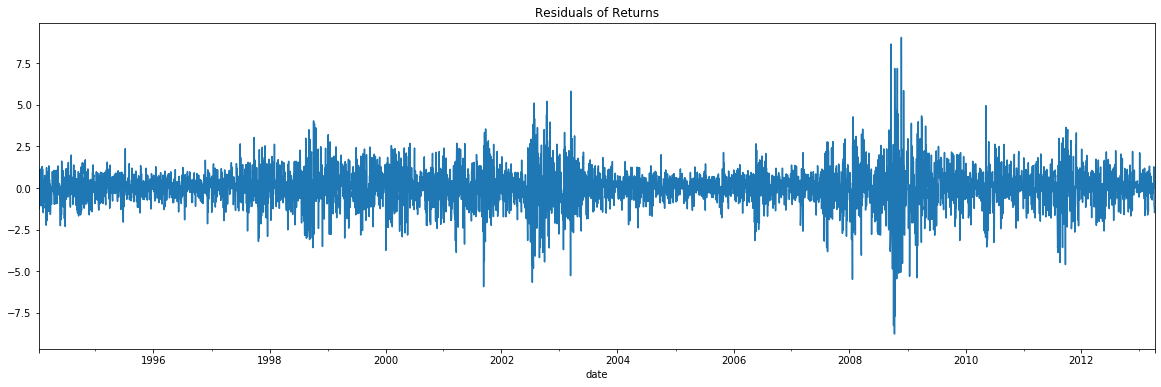

In [60]:
#plot of residuals
train.resids_ret_ma8.plot(figsize=(20,6))
plt.title('Residuals of Returns')
plt.show()

To see if the residuals fit a white noise process, we test for stationarity using the ADF test

In [61]:
sts.adfuller(train.resids_ret_ma8[1:])

(-70.8382186723942,
 0.0,
 0,
 5019,
 {'1%': -3.4316535759402753,
  '5%': -2.8621160400844468,
  '10%': -2.567076626752987},
 15689.881919867423)

ADF test says residuals series is stationary. However note that stationarity does not mean/imply white noise (completely random). To check this we can look at the ACF plot of the residuals to see if the coefficients appear randomly and are significant

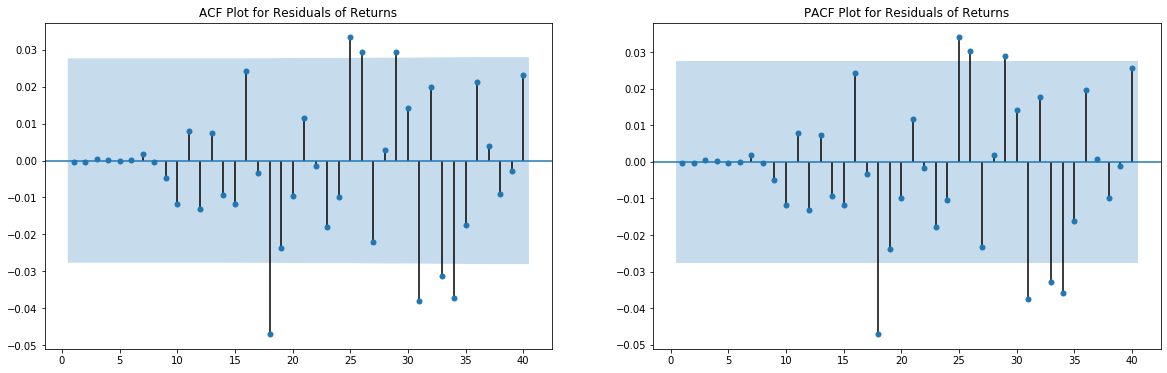

In [62]:
ACF_and_PACF(train.resids_ret_ma8[1:],'Residuals of Returns')

Homework:
- CHeck MA(6) model to see if it performs better. Could you make a case to use the simpler model instead?

### Normalized Returns MA models
The ACF should look very similar to that of the returns and therefore the same model outcomes are suggested (MA 6 or MA 8 model) because normalized and unnormalized data will have the same optimal model.

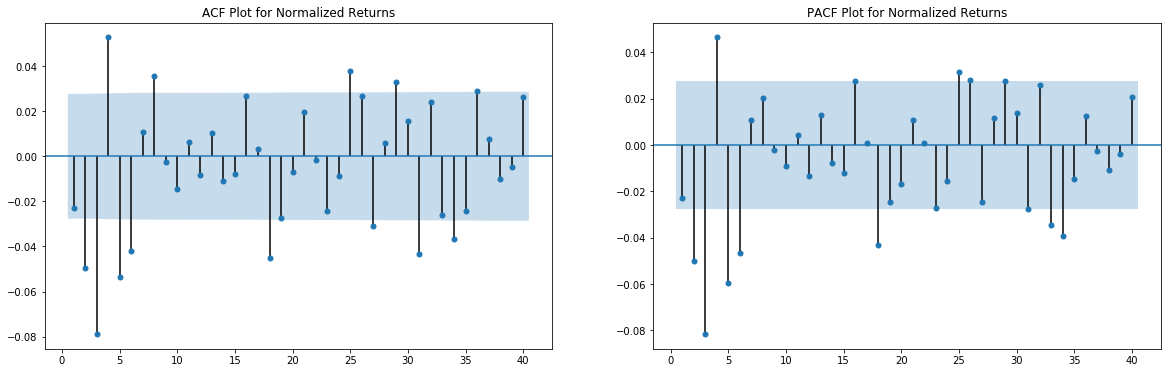

In [64]:
ACF_and_PACF(train.norm_ret[1:], 'Normalized Returns')

In [65]:
model_ret_ma8 = ARMA(train.norm_ret[1:], order=(0,8))
results_ret_ma8 = model_ret_ma8.fit()
train['resids_norm_ret_ma8'] = results_ret_ma8.resid
train.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,market_value,returns,norm_ret,resids_ret_ma8,resids_norm_ret_ma8
date,,,,,
1994-01-07,3445.98,NaN,NaN,NaN,NaN
1994-01-10,3440.58,-0.156704,100.000000,-0.175611,111.973059
1994-01-11,3413.77,-0.779229,497.260711,-0.802111,511.768586
1994-01-12,3372.02,-1.222988,780.443046,-1.269464,810.002551
1994-01-13,3360.01,-0.356166,227.285567,-0.464780,296.489539


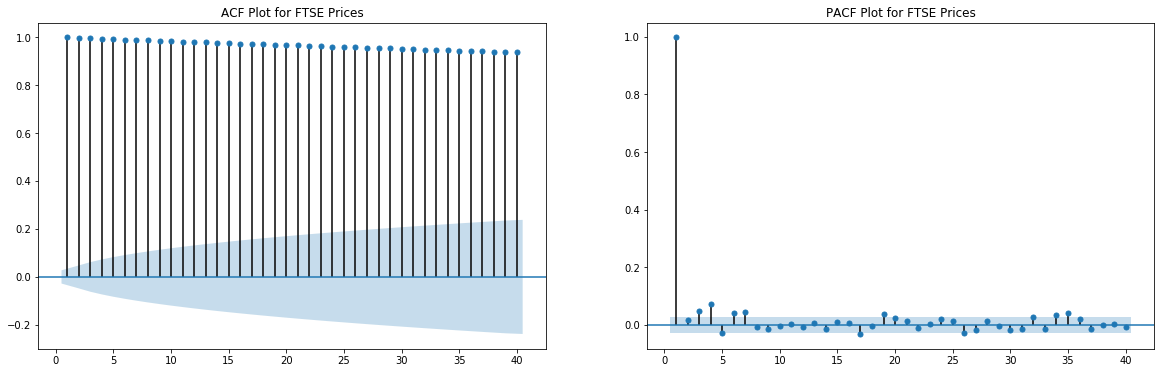

In [66]:
### MA(1) model for Prices
ACF_and_PACF(train.market_value, 'FTSE Prices')

Note: since all values are significant, then this suggests higher order models will always be better than lower order ones. If we extend this n lags, we would have an MA model with infinite lags which is impossible to accomplish. This tells us that MA models, though good at accounting for past season errors, do not do a good job for prices like seen above because it tries to maximize the previous periods errors when estimating current period (i.e. the effect never dies off and is large and permanent). Given this, AR models are good to use because they also account for t-1 error while also modeling the previous period's values. We therefore learn that by themselves, AR and MA models are not good for predictions with non-stationary series. However, even when made stationary, the residuals do not completely resemble white noise. Therefore we opt to combine the two forms to use ARMA models for modeling prices.

**In summary**
- AR alone: accounts for past values but takes time to account for past errors
- MA alone: accounts for past errors but does not have a baseline value from which to model errors
- ARMA = accounts for both past values and past errors